In [31]:
import os
import sys
import pandas as pd
import numpy as np

# For notebooks — get the current working directory
notebook_dir = os.getcwd()
project_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(project_dir)

# Then import your module
import Utils.functions as data_viz
import Utils.file_io as file_io

from dotenv import load_dotenv
load_dotenv()

csv_export_config = {'datasets_raw': 
                        {'save_csv': False,
                        'file_title': 'data_raw'},
                     'datasets_cleaned': 
                        {'save_csv': False,
                        'file_title': 'data_clean'},
                     'datasets_features': 
                        {'save_csv': True,
                        'file_title': 'data_features'}
}

png_export_config = {'png_raw': # not created
                        {'save_png': False,
                        'file_title': 'data_raw'},
                    'png_features': 
                        {'save_png': True,
                        'file_title': 'png_features'}
}

# Script to Retrieve data from FRED

In [32]:
series_codes = {
    'GS10': '10-Year Yield',
    'DGS2': '2-Year Yield',
    'DGS3MO': '3-Month Yield',
    #'UNRATE': 'UnemploymentRate'
}

##! python3 Dataset/get_data.py
load_dotenv(dotenv_path=os.path.join(project_dir, "api.env"))
fred_api_key = os.getenv("MY_API_KEY") 
df_raw = file_io.get_fred_data(series_codes = series_codes, FRED_API_KEY = fred_api_key, 
                               output_csv_flag = csv_export_config['datasets_raw']['save_csv'], 
                               filename = csv_export_config['datasets_raw']['file_title'])


In [33]:
'''
csv_export_config.update({'datasets_cleaned': {
                            'save_csv': False,
                            'file_title': 'data_clean'},
                          'datasets_features': {
                            'save_csv': True,
                            'file_title': 'data_features'},



})
'''

"\ncsv_export_config.update({'datasets_cleaned': {\n                            'save_csv': False,\n                            'file_title': 'data_clean'},\n                          'datasets_features': {\n                            'save_csv': True,\n                            'file_title': 'data_features'},\n\n\n\n})\n"

# Data Exploration and Cleaning

Number of Entries: 13264
Missing entries in 10-Year Yield: 	 12397 	 93.46%
Missing entries in 2-Year Yield: 	 986 	 7.43%
Missing entries in 3-Month Yield: 	 2296 	 17.31%


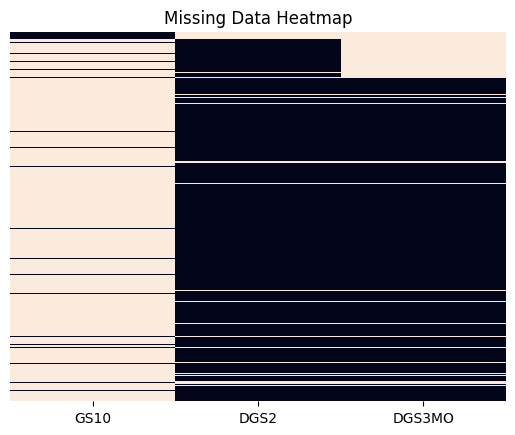

In [34]:
# Check for missing data
print(f"Number of Entries: {len(df_raw)}")

for key, item in df_raw.isnull().sum().items():
    percent_missing = 100 * item / len(df_raw)
    print(f"Missing entries in {series_codes[key]}: \t {item} \t {percent_missing:.2f}%")

data_viz.vis_missing_data(df_raw)

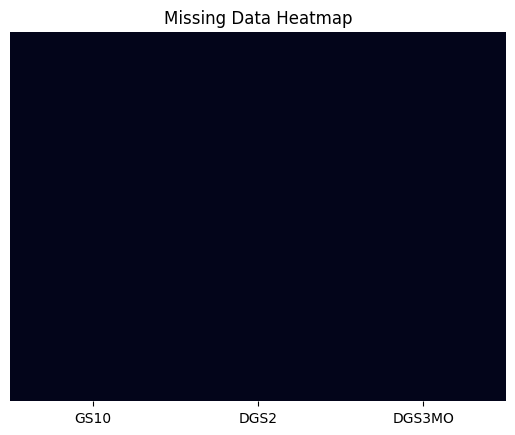

In [35]:
# Missing data would be handled with forward fill and previous entries would be removed
df_clean = df_raw.ffill().dropna()
data_viz.vis_missing_data(df_clean)

#Export to CSV
file_io.output_csv(dataframe=df_clean, 
                   flag = csv_export_config['datasets_cleaned']['save_csv'], 
                   file_name = csv_export_config['datasets_cleaned']['file_title'])
#file_io.output_csv(dataframe=df_clean, flag = False, file_name = 'data_clean')

# Feature Engineering

In [36]:
#print(f"{project_dir}/Dataset/recession_periods.csv")

#df_list_of_recessions = pd.read_csv(f"{project_dir}/Dataset/recession_periods.csv")


#or row in df_list_of_recessions.itertuples(index=False):
#   print(row.start, row.end, row.color, row.recession_label)


DataFrame saved to Dataset/data_features.csv


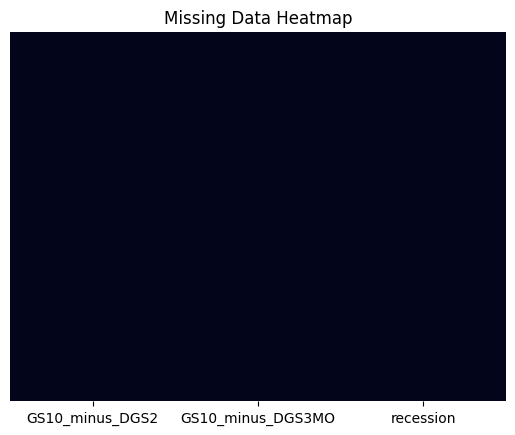

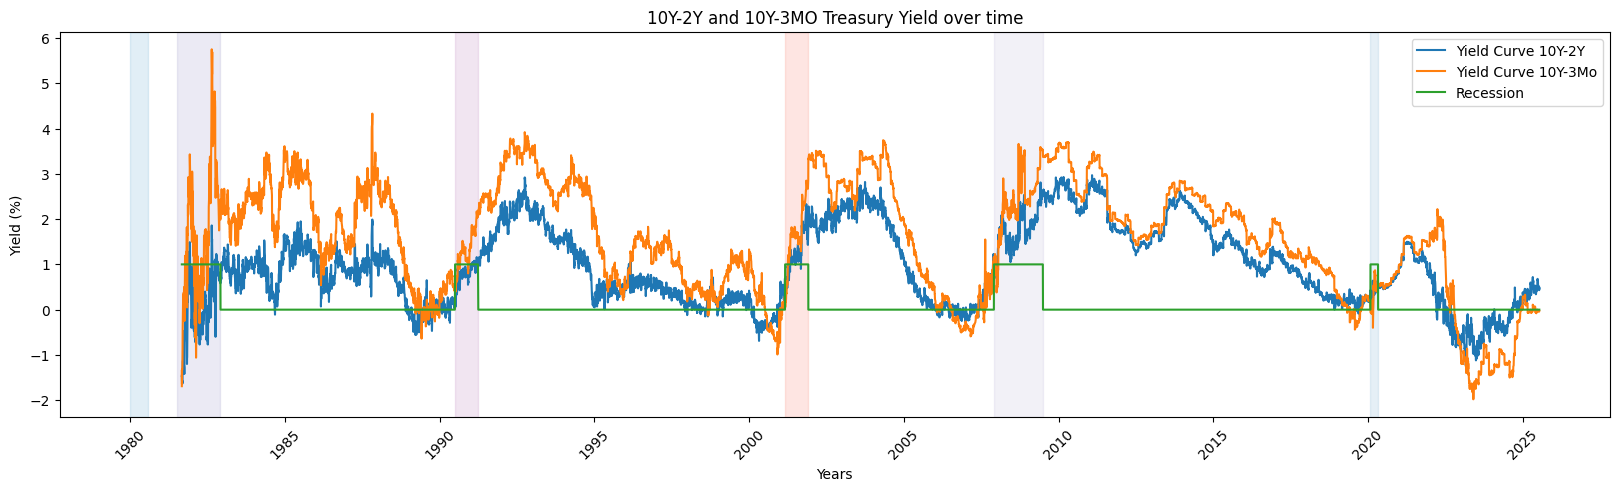

Plot saved to plot/png_features.png


In [37]:
"""We would be creating 3 features
1- GS10 minus DGS2 : GS10_minus_DGS2
2- GS10 minus DGS3MO : GS10_minus_DGS3MO
3- Label Column : recession
"""
df_features = pd.DataFrame()
df_features['GS10_minus_DGS2'] = (df_clean['GS10'] - df_clean['DGS2']).round(4)
df_features['GS10_minus_DGS3MO'] = (df_clean['GS10'] - df_clean['DGS3MO']).round(4)

series_codes.update({'GS10_minus_DGS2': 'Yield Curve 10Y-2Y',
                     'GS10_minus_DGS3MO': 'Yield Curve 10Y-3Mo',
                     'recession': 'Recession'})

df_list_of_recessions = pd.read_csv(f"{project_dir}/Dataset/recession_periods.csv")
df_features['recession'] = 0
for row in df_list_of_recessions.itertuples(index=False):
    mask = (df_features.index >= pd.to_datetime(row.start)) & \
           (df_features.index <= pd.to_datetime(row.end))
    df_features.loc[mask, 'recession'] = 1


#Export to CSV
file_io.output_csv(dataframe=df_features, 
                   flag = csv_export_config['datasets_features']['save_csv'], 
                   file_name = csv_export_config['datasets_features']['file_title'])

data_viz.vis_missing_data(df_features)
_, fig = data_viz.line_plot(dataframe = df_features, labels = series_codes, 
                            plot_title="10Y-2Y and 10Y-3MO Treasury Yield over time" , 
                            df_recessions = df_list_of_recessions)
file_io.output_png(fig=fig, flag = png_export_config['png_features']['save_png'], 
                   file_name = png_export_config['png_features']['file_title'])

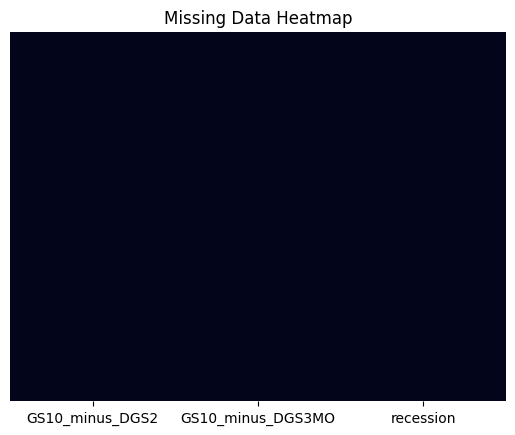

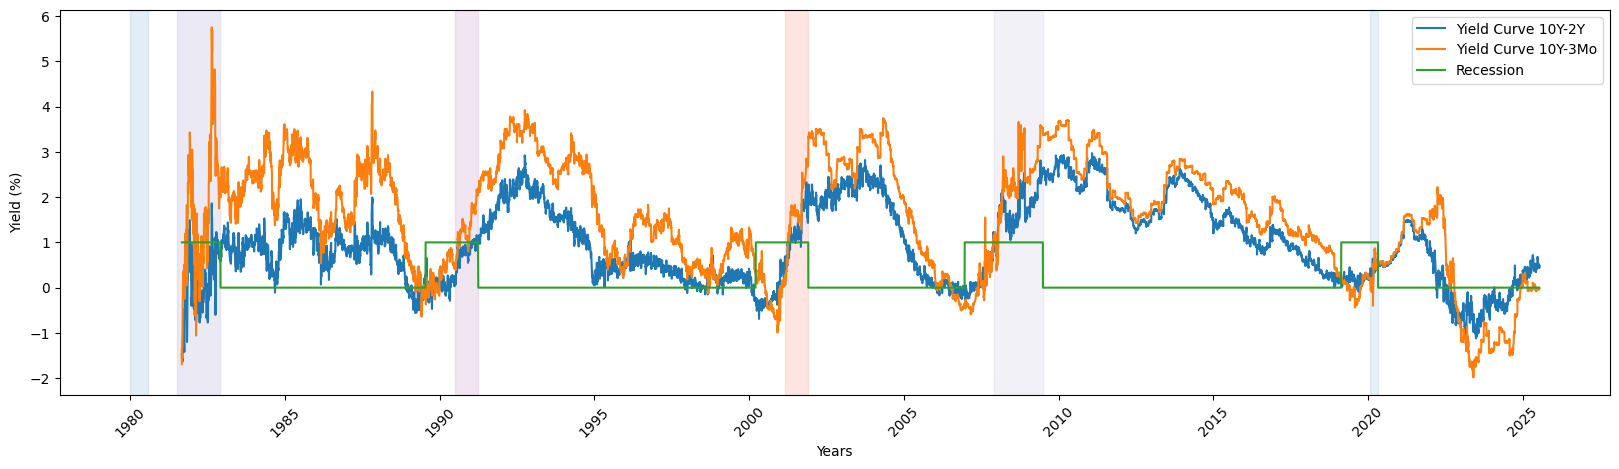

In [38]:
# forward-looking window featrue engineering
df_features.rename(columns={'recession': 'recession_'}, inplace=True)


recession_dates = df_features['recession_'].values
horizon = 252 #~1 year of trading days
future_recession = np.zeros_like(recession_dates)
for i in range(len(recession_dates)):
    if 1 in recession_dates[i:i+horizon]:
        future_recession[i] = 1

df_features['recession'] = future_recession
del df_features['recession_']

data_viz.vis_missing_data(df_features)

_, fig = data_viz.line_plot(dataframe = df_features, labels = series_codes, plot_title='', df_recessions = df_list_of_recessions)

In [39]:
# Create 2 extra versions of df_features  

# Daily
df_features_daily = df_features.copy()

# WEEKLY AVERAGES (label at mid‑month)
df_features_weekly = (df_features.resample('W-FRI').mean()).round(4)
df_features_weekly.index = df_features_weekly.index - pd.offsets.Day(2)

# MONTHLY AVERAGES (label at mid‑month)
df_features_monthly = (df_features.resample('ME').mean()).round(4)
df_features_monthly.index = df_features_monthly.index - pd.offsets.DateOffset(days=14)

dict_features = {'Daily': df_features_daily,
                 'Weekly': df_features_weekly,
                 'Monthly': df_features_monthly
}

#Export to CSV
for name, df in dict_features.items():
    file_io.output_csv(dataframe=df, 
                   flag = csv_export_config['datasets_features']['save_csv'], 
                   file_name = f'{csv_export_config['datasets_features']['file_title']}_{name.lower()}')

DataFrame saved to Dataset/data_features_daily.csv
DataFrame saved to Dataset/data_features_weekly.csv
DataFrame saved to Dataset/data_features_monthly.csv


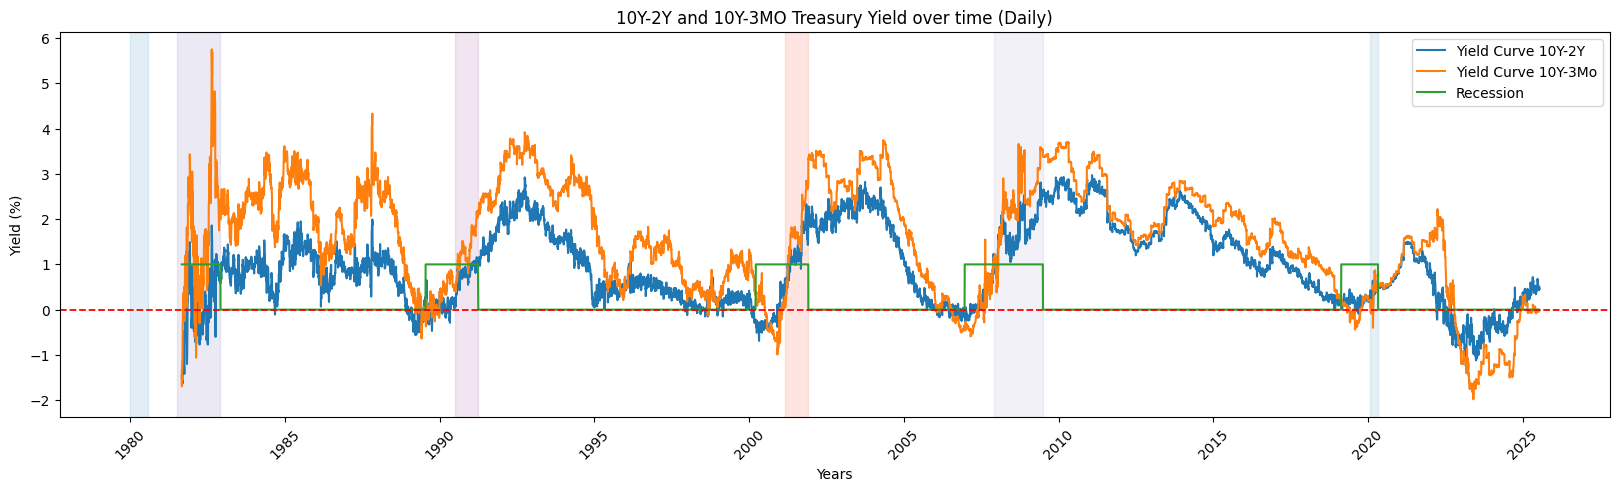

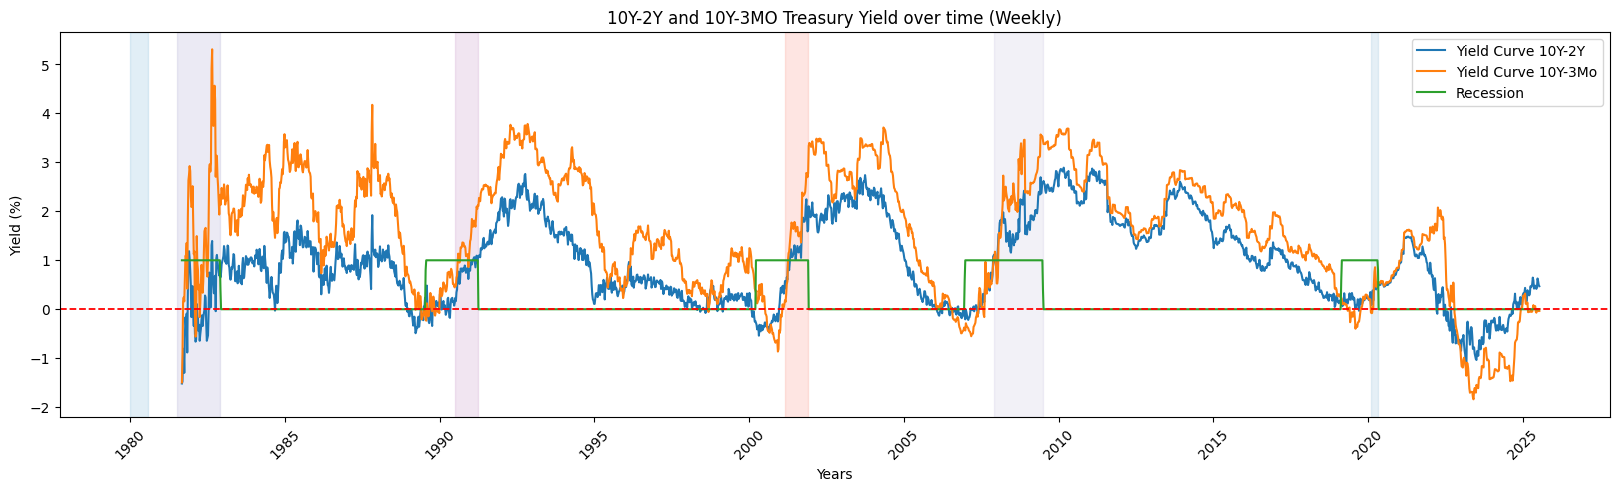

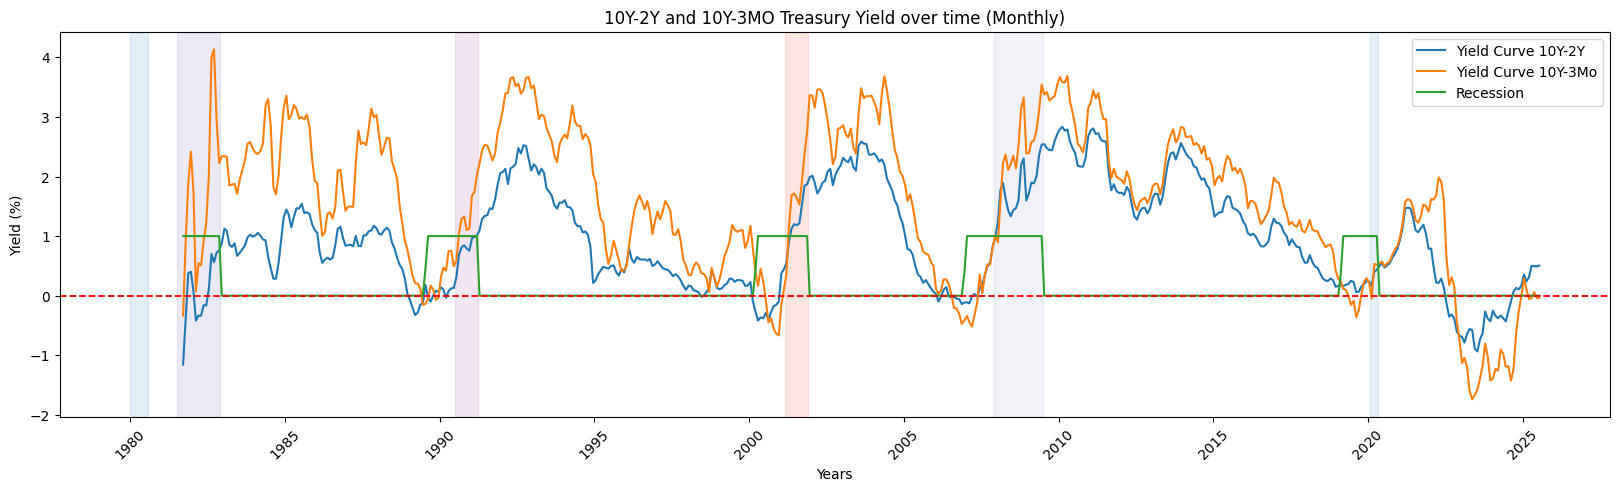

In [40]:
for name, df in dict_features.items():
    name1 = "10Y-2Y and 10Y-3MO Treasury Yield over time"
    full_name = f"{name1} ({name})"
    _, fig = data_viz.line_plot(df, series_codes, plot_title=full_name, hlines={0: 'red'}, df_recessions = df_list_of_recessions)